In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/income_data.csv')

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [5]:
cat_columns = ['sex', 'education', 'race']
cont_columns = ['age', 'hours-per-week']
features = cat_columns + cont_columns
target = 'target'

## Step 1: Make a pipeline

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [16]:
# transformations on the categoricals
cat_trans = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',
                             min_frequency=0.05, # make 'infrequent' column for classes wit freq. < 5%
                             handle_unknown='infrequent_if_exist' # label unknown classes as 'infequent'
                            ))])

In [17]:
# transformations on the continuous features
cont_trans = Pipeline(steps=[('scaler', StandardScaler())])

In [18]:
# full feature transform
feat_trans = ColumnTransformer(
    transformers=[('categorical', cat_trans, cat_columns),
                  ('continuous', cont_trans, cont_columns)])

### Models

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [20]:
def mk_knn(k):
    return Pipeline(steps=[
        ('feature_transform', feat_trans),
        ('model', KNeighborsClassifier(n_neighbors=k))])

In [21]:
mk_knn(20)

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'hours-per-week'])])),
                ('model', KNeighborsClassifier(n_neighbors=20))])

In [22]:
def mk_tree(d):
    return Pipeline(steps=[
        ('feature_transform', feat_trans),
        ('model', DecisionTreeClassifier(max_depth=d))])

In [23]:
mk_tree(3)

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'hours-per-week'])])),
                ('model', DecisionTreeClassifier(max_depth=3))])

## Model presistence

In [24]:
import pickle

In [26]:
s = pickle.dumps(mk_tree(10))

In [28]:
pickle.loads(s) # warning, potential cyber security risk

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'hours-per-week'])])),
                ('model', DecisionTreeClassifier(max_depth=10))])

In [29]:
# better way:
mk_tree(3).fit(df[features], df[target])

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'hours-per-week'])])),
                ('model', DecisionTreeClassifier(max_depth=3))])

## Model evaluation

In [30]:
from sklearn.model_selection import train_test_split
import sklearn.metrics

In [31]:
df.shape

(32561, 16)

In [40]:
Xtr, Xte, ytr, yte = train_test_split(df[features], df[target], test_size=0.3)

In [41]:
sklearn.metrics.accuracy_score(yte, mk_tree(5).fit(Xtr, ytr).predict(Xte))

0.7841130105435562

In [43]:
# reproducible
Xtr, Xte, ytr, yte = train_test_split(df[features], df[target], test_size=0.3, random_state=42)
sklearn.metrics.accuracy_score(yte, mk_tree(5).fit(Xtr, ytr).predict(Xte))

0.7863650322448562

### Which model is better?

In [48]:
sklearn.metrics.accuracy_score(yte, mk_knn(30).fit(Xtr, ytr).predict(Xte)) # point estimate!

0.7978298699969291

In [47]:
sklearn.metrics.accuracy_score(yte, mk_tree(10).fit(Xtr, ytr).predict(Xte)) # point estimate!

0.7906643464018835

NB: Could use bootstrapping, but with train/test split, the same data point might end up in train and test sets.

## K-fold

In [57]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, ShuffleSplit

In [60]:
cross_val_score(mk_knn(30), df[features], df[target], cv=50)

array([0.78067485, 0.79907975, 0.77760736, 0.82208589, 0.7791411 ,
       0.79294479, 0.7898773 , 0.79447853, 0.79141104, 0.80981595,
       0.79141104, 0.80337942, 0.79877112, 0.80645161, 0.79416283,
       0.78955453, 0.79416283, 0.80030722, 0.80030722, 0.79877112,
       0.8156682 , 0.78494624, 0.80030722, 0.82949309, 0.78648233,
       0.79262673, 0.80952381, 0.80491551, 0.80645161, 0.77572965,
       0.79877112, 0.78648233, 0.77880184, 0.80184332, 0.78341014,
       0.80491551, 0.8202765 , 0.8202765 , 0.79262673, 0.78801843,
       0.79723502, 0.79262673, 0.79109063, 0.81259601, 0.79262673,
       0.78955453, 0.77880184, 0.80645161, 0.79262673, 0.77419355])

In [61]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

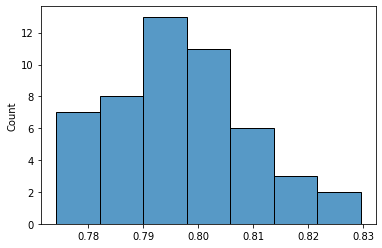

In [62]:
sns.histplot(cross_val_score(mk_knn(30), df[features], df[target], cv=50))

In [63]:
cross_val_score(mk_knn(30), df[features], df[target], cv=ShuffleSplit(10))

array([0.79613141, 0.79428922, 0.79920172, 0.79152594, 0.80012281,
       0.79336813, 0.78599939, 0.79152594, 0.78968376, 0.80042984])

In [64]:
cross_val_score(mk_knn(30), df[features], df[target], cv=ShuffleSplit(10)) # non-reproducible

array([0.79613141, 0.78937673, 0.79920172, 0.77740252, 0.79091188,
       0.80135094, 0.78446423, 0.78999079, 0.7890697 , 0.79551735])

In [65]:
cross_val_score(mk_knn(30), df[features], df[target], cv=ShuffleSplit(10, random_state=42))

array([0.79735953, 0.80104391, 0.79060485, 0.78446423, 0.79858766,
       0.79152594, 0.79244704, 0.79367516, 0.79275407, 0.79459625])

## Scarce data -> Leave One Out CV

In [96]:
df_scarce = df.sample(200)

In [97]:
from sklearn.model_selection import LeaveOneOut

In [98]:
leave_oo_cv = cross_val_score(mk_tree(3), df_scarce[features], df_scarce[target], cv=LeaveOneOut())

/Users/DIRH/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/DIRH/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/DIRH/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [99]:
leave_oo_cv

array([1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1.])

In [100]:
leave_oo_cv.mean()

0.615

In [101]:
n, k = leave_oo_cv.shape[0], leave_oo_cv.sum()

In [102]:
import scipy
import matplotlib.pyplot as plt

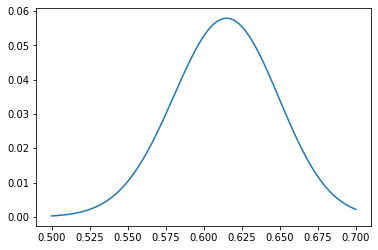

In [104]:
ps = numpy.linspace(0.5, 0.7, 100)
plt.plot(ps, scipy.stats.binom.pmf(k=k, n=n, p=ps))

In [105]:
df_scarce['target'].mean()

0.255

### Attention, cross_val_score == stratified 

<AxesSubplot:ylabel='Count'>

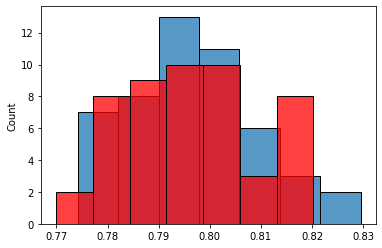

In [68]:
sns.histplot(cross_val_score(mk_knn(30), df[features], df[target], cv=StratifiedKFold(50)))
sns.histplot(cross_val_score(mk_knn(30), df[features], df[target], cv=KFold(50)), color='red')

## Shooting yourself in the foot

In [69]:
from sklearn.linear_model import LogisticRegression
import numpy

In [70]:
from sklearn.feature_selection import SelectKBest

In [71]:
k, N = 5000, 500

In [72]:
X = numpy.random.rand(k*N).reshape(N, k)

In [73]:
y = numpy.random.choice([0, 1], N)

In [75]:
Xp = SelectKBest(k=10).fit_transform(X, y)

In [76]:
cross_val_score(LogisticRegression(), Xp, y)

array([0.65, 0.7 , 0.66, 0.66, 0.63])

In [77]:
cv_scores = pd.DataFrame({
    'full_data': cross_val_score(LogisticRegression(), X, y, cv=20),
    'k_best': cross_val_score(LogisticRegression(), Xp, y, cv=20)})

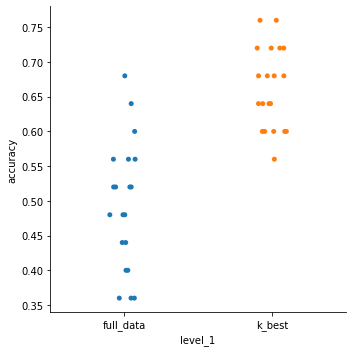

In [78]:
sns.catplot(data=cv_scores.stack().reset_index(name='accuracy'), x='level_1', y='accuracy')

## The correct way

In [82]:
model = Pipeline(steps=[
    ('select', SelectKBest(k=10)),
    ('logistic reg.', LogisticRegression())])

In [83]:
cross_val_score(model, X, y, cv=20)

array([0.48, 0.36, 0.48, 0.36, 0.4 , 0.52, 0.52, 0.44, 0.56, 0.44, 0.36,
       0.52, 0.44, 0.56, 0.44, 0.48, 0.32, 0.48, 0.48, 0.48])

# Model Selection

## Grid search

In [106]:
from sklearn.model_selection import GridSearchCV

In [108]:
param_grid = {'model__max_depth': [2,3,4,5,6]} # warning: combinatorics if using multipe parameters
grid_search = GridSearchCV(mk_tree(1), param_grid, cv=10) # depth 1 doesn't mean anything, will be changed

In [109]:
fit_result = grid_search.fit(df[features], df[target])

In [110]:
fit_result

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('feature_transform',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='infrequent_if_exist',
                                                                                                        min_frequency=0.05))]),
                                                                         ['sex',
                                                                          'education',
                                                                          'race']),
                                                                        ('continuous',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'hours-per-week'])])),
                                       ('model',
                                        DecisionTreeClassifier(max_depth=1))]),
             param_grid={'model__max_depth': [2, 3, 4, 5, 6]})

In [114]:
fit_result.best_estimator_.get_params()['steps'][1]

('model', DecisionTreeClassifier(max_depth=6))